In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Conversión de unidades de valores físicos

In [2]:
    ###Valores reportados en literatura###
#Difusividad cloruro
DC_A = 6.8*1e-12   #En arcilla [m^2/s]
DC_T = 5*1e-10 #En tierra [m^2/s]
#Difusividad nitrato
DN_A = 1.7*1e-11 #En arcilla [m^2/s]
DN_T = 5*1e-10 #En tierra [m^2/s]
#Velocidades de adveccion
VC = 3*1e-6     #[m/s]
VN = 2*1e-7     #[m/s]

    ###Adaptacion a unidades de interes###
t = 60*60*24*30   #Cantidad de segundos en 30 días
#Difusividad cloruro
DC_A1 = DC_A*1e4*t   #En arcilla [cm^2/mes]
DC_T1 = DC_T*1e4*t   #En tierra  [cm^2/mes]
#Difusividad nitrato
DN_A1 = DN_A*1e4*t   #En arcilla [cm^2/mes]
DN_T1 = DN_T*1e4*t   #En tierra  [cm^2/mes]
#Velocidades
VC1 = VC*100*t     #[cm/mes]
VN1 = VN*100*t     #[cm/mes]


    ###Valores estimados###
#Coeficiente de transferencia de masa en la entrada
k1_0 = 2*1e-12      #[m/s]
k1 = k1_0*100*t     #[cm/mes]
#Coeficientes de transferencia de masa en la salida
k2C_0 = 5*1e-7       #[m/s]
k2N_0 = 1.5*1e-4     #[m/s]
k2C = k2C_0*100*t    #[cm/mes]
k2N = k2N_0*100*t    #[cm/mes]

## Definicion de parámetros

In [3]:
           ##Paso computacional##
dt = 1 #Delta t [mes]
dz = 1 #Delta z [cm]

           #####Valores de parametros físicos#####
#Parametros de cloruro
DifC = [DC_A1,DC_T1] #Coeficientes de difusividad en arcilla y tierra
VelC = VC1 #Velocidades de adveccion en arcilla y tierra
#Parametros de nitrato
DifN = [DN_A1,DN_T1] #Coeficientes de difusividad en arcilla y tierra
VelN = VN1 #Velocidades de adveccion en arcilla y tierra



           #####Coeficientes de discretizacion FTCS#####
#Cloruro
# Coeficientes en arcilla
A_C = DifC[0]*dt/(dz**2)                        #Termino que multiplica C_{i-1}
B_C = 1 - 2*DifC[0]*dt/(dz**2)                  #Termino que multiplica C_{i}
C_C = DifC[0]*dt/(dz**2)                        #Termino que multiplica C_{i+1}
#Coeficientes en tierra
E_C = DifC[1]*dt/(dz**2) + VelC*dt/(2*dz)       #Termino que multiplica C_{i-1}
F_C = 1 - 2*DifC[1]*dt/(dz**2)                  #Termino que multiplica C_{i}
G_C = DifC[1]*dt/(dz**2) - VelC*dt/(2*dz)       #Termino que multiplica C_{i+1}

#Nitrato
# Coeficientes en arcilla
A_N = DifN[0]*dt/(dz**2)                        #Termino que multiplica C_{i-1} 
B_N = 1 - 2*DifN[0]*dt/(dz**2)                  #Termino que multiplica C_{i}
C_N = DifN[0]*dt/(dz**2)                        #Termino que multiplica C_{i+1}
#Coeficientes en tierra
E_N = DifN[1]*dt/(dz**2) + VelN*dt/(2*dz)       #Termino que multiplica C_{i-1}
F_N = 1 - 2*DifN[1]*dt/(dz**2)                  #Termino que multiplica C_{i}
G_N = DifN[1]*dt/(dz**2) - VelN*dt/(2*dz)       #Termino que multiplica C_{i+1}
varphiN = 2*dz*(VelN-k2N)/DifN[1]                #Constante adicional del nodo de salida


           #####Coeficientes de discretizacion condicion de borde de entrada#####
#Cloruro
gammaC = dz*k1/DifC[0]                          #Termino que multiplica C_{ext} en nodo de entrada
phiC = 1-gammaC                                 #Termino que multiplica C_{0} en nodo de entrada
#Nitrato
gammaN = dz*k1/DifN[0]                          #Termino que multiplica C_{ext} en nodo de entrada
phiN = 1-gammaN                                 #Termino que multiplica C_{0} en nodo de entrada


#Definicion de betas involucrados en continuidad de flujo intercapas
K1 = 2*DifC[0]*DifC[1]/(dz*(DifC[0]+DifC[1])) #Cloruro
K2 = 2*DifN[0]*DifN[1]/(dz*(DifN[0]+DifN[1])) #Nitrato
KstarC = K1*dt/dz
KstarN = K2*dt/dz


           #####Coeficientes de discretizacion condicion de borde de entrada#####
#Cloruro
varphiC = 2*dz*(VelC-k2C)/DifC[1]                
#Nitrato
varphiN = 2*dz*(VelN-k2N)/DifN[1]                

        ####################################### 
        #####Almacenamiento de coeficientes#### 
        #######################################  
         
        #Coef. en arcilla#  #Coef. en tierra#  #Coef. K#        
Clo = [[A_C,B_C,C_C,phiC],[E_C,F_C,G_C,varphiC],KstarC]
Nit = [[A_N,B_N,C_N,phiN],[E_N,F_N,G_N,varphiN],KstarN]

## Definición de grilla computacional

In [4]:
#ESPACIO#
N = 361
Grilla_z = np.linspace(0,360,361) # Un total de 361 nodos por incluir el punto z=0
#TIEMPO#


## Definicion de matriz de coeficientes

In [5]:
def MATRIX(Coef):
  # "Dif" es el vector de coeficientes de difusividad
  # "Coef" corresponde a la matriz de coeficientes a utilizar en la discrestización para un compuesto particular
  A, B, C, phi = Coef[0][0],Coef[0][1],Coef[0][2],Coef[0][3]  #Coeficientes asociados al transporte en arcilla
  E, F, G, vphi = Coef[1][0],Coef[1][1],Coef[1][2], Coef[1][3]  #Coeficientes asociados al transporte en tierra
  K_star = Coef[2]

  #Esqueleto matricial inicial
  M = np.zeros([N,N])

  #Incorporacion de coeficientes
  for i in range(0,N):
    
    #Condicion de borde superior: Flux de entrada es proporcional a diferencia de concentraciones en geomembrana
    if i == 0:
      M[i][i] = A*phi+B
      M[i][i+1] = C   

    #Seccion representativa de la capa de arcilla
    elif i < 60:
      M[i][i-1] = A  
      M[i][i] = B     
      M[i][i+1] = C  

    #Interface 
    elif i == 60:
      M[i][i-1] = A  
      M[i][i] = 1 - A - K_star     
      M[i][i+1] = K_star  

    elif i == 61:
      M[i][i-1] = K_star  
      M[i][i] = 1 - E - K_star     
      M[i][i+1] = E  
    
    #Seccion representativa de la capa de tierra
    elif i >61 and i<360:
      M[i][i-1] = E     
      M[i][i] = F       
      M[i][i+1] = G 

    #Condicion de borde inferior:  Flux de salida es proporcional a diferencia de concentraciones tierra-acuifero
    elif i ==360:
      M[i][i-1] = E + G 
      M[i][i]   = F + G*vphi
  return M

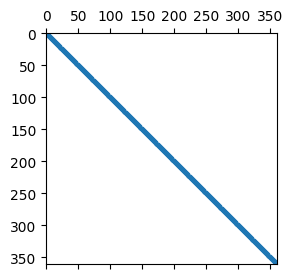

In [6]:
#Definicion de matrices para cada uno de los contaminantes
#Matriz cloruro
A1 = MATRIX(Clo)
#Matriz nitrato
A2 = MATRIX(Nit)

#Visualización
fig,ax=plt.subplots(1,1,figsize=[3,3])
ax.spy(A1,markersize=2)
plt.show()

Vector no lineal

In [8]:
#Funcion no lineal de la concentracion de entrada
C0 = 10000000.  #[mol/cm^3]
C1 = 0.002      #[mol/cm^3]
C2 = 0.003
def b(tiempo):
    v = np.zeros([N])
    v[0] = C0-C1*np.exp(C2*tiempo)
    return v

## Estimación numérica del perfil de concentraciones

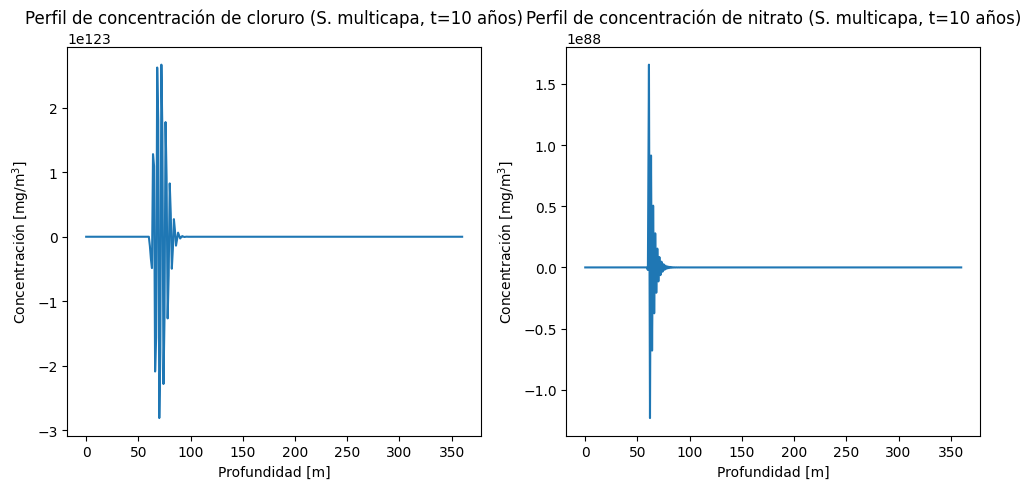

In [16]:
#Concentracion inicial de cloruro en t=0
C0_C = np.zeros(N)
#Concentracion inicial de nitrato en t=0
C0_N = np.zeros(N)



            #Evolucion de concentracion de contaminantes en el tiempo#


t0 = 0
tmax = 12*10 #30 años - 5 s
while t0 < tmax:
    #Evolucion cloruro
    C_new1 = A1@C0_C + (Clo[0][0]*gammaC)*b(t0) 
    C0_C = np.copy(C_new1)
    t0+=1

t02 = 0
while t02 < tmax:
    #Evolucion cloruro
    C_new2 = A2@C0_N + (Nit[0][0]*gammaN)*b(t02) 
    C0_N = np.copy(C_new2)
    t02+=1    


fig, ax = plt.subplots(1,2,figsize =[10,5])

ax[0].plot(Grilla_z,C0_C)
ax[0].set_xlabel("Profundidad [m]")
ax[0].set_ylabel(r"Concentración [mg/m$^3$]")
ax[0].set_title("Perfil de concentración de cloruro (S. multicapa, t=10 años)")

ax[1].plot(Grilla_z,C0_N)
ax[1].set_xlabel("Profundidad [m]")
ax[1].set_ylabel(r"Concentración [mg/m$^3$]")
ax[1].set_title("Perfil de concentración de nitrato (S. multicapa, t=10 años)")
plt.tight_layout()
plt.show()